# Úkol č. 1 - předzpracování dat a binární klasifikace

* Termíny jsou uvedeny na [courses.fit.cvut.cz](https://courses.fit.cvut.cz/BI-ML1/homeworks/index.html).
* Pokud odevzdáte úkol po prvním termínu ale před nejzašším termínem, budete penalizování -12 body, pozdější odevzdání je bez bodu.
* V rámci tohoto úkolu se musíte vypořádat s klasifikační úlohou s příznaky různých typů.
* Před tím, než na nich postavíte predikční model, je třeba je nějakým způsobem převést do číselné reprezentace.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budeme strhávat body.

## Zdroj dat

Budeme se zabývat predikcí přežití pasažérů Titaniku.
K dispozici máte trénovací data v souboru `data.csv` a data na vyhodnocení v souboru `evaluation.csv`.

#### Seznam příznaků:
* survived - zda pasažér přežil, 0 = Ne, 1 = Ano, **vysvětlovaná proměnná**, kterou chcete predikovat
* pclass - Třída lodního lístku, 1 = první, 2 = druhá, 3 = třetí
* name - jméno
* sex - pohlaví
* age - věk v letech
* sibsp	- počet sourozenců / manželů, manželek na palubě
* parch - počet rodičů / dětí na palubě
* ticket - číslo lodního lístku
* fare - cena lodního lístku
* cabin	- číslo kajuty
* embarked	- místo nalodění, C = Cherbourg, Q = Queenstown, S = Southampton
* home.dest - Bydliště/Cíl

## Pokyny k vypracování

**Body zadání**, za jejichž (poctivé) vypracování získáte **25 bodů**: 
  * V notebooku načtěte data ze souboru `data.csv`. Vhodným způsobem si je rozdělte na podmnožiny, které Vám poslouží pro trénování (trénovací), porovnávání modelů (validační) a následnou predikci výkonnosti finálního modelu (testovací).
    
  * Proveďte základní předzpracování dat:
    * Projděte si jednotlivé příznaky a transformujte je do vhodné podoby pro použití ve vybraném klasifikačním modelu.
    * Podle potřeby si můžete vytvářet nové příznaky (na základě existujících), například tedy můžete vytvořit příznak měřící délku jména atp.
    * Některé příznaky můžete také úplně zahodit.
    * Nějakým způsobem se vypořádejte s chybějícími hodnotami. _Pozor na metodické chyby!_
    * Můžete využívat i vizualizace a vše stručně ale náležitě komentujte.

  
  * Na připravená data postupně aplikujte **rozhodovací strom** a **metodu nejbližších sousedů**, přičemž pro každý z těchto modelů:
    * Okomentujte vhodnost daného modelu pro daný typ úlohy.
    * Vyberte si hlavní hyperparametry k ladění a najděte jejich nejlepší hodnoty.
    * Pro model s nejlepšími hodnotami hyperparametrů spočtěte F1 skóre, nakreslete ROC křivku a určete AUC. _Pozor na metodické chyby!_
    * Získané výsledky vždy řádně okomentujte.

        
  * Ze všech zkoušených možností v předchozím kroku vyberte finální model a odhadněte, jakou přesnost můžete očekávat na nových datech, která jste doposud neměli k dispozici. _Pozor na metodické chyby!_
    
  * Nakonec načtěte vyhodnocovací data ze souboru`evaluation.csv`. Pomocí finálního modelu napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte soubor `results.csv`, ve kterém získané predikce uložíte do dvou sloupců: **ID**, **survived**. Tento soubor též odevzdejte (uložte do repozitáře vedle notebooku).

  * Ukázka prvních řádků souboru `results.csv`:
  
```
ID,survived
1000,0
1001,1
...
```

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML1/homeworks/index.html.

# Data preparation

In [93]:
# import the required libs
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [94]:
# reading data
data = pd.read_csv('data.csv')
display(data.shape)
display(data.head())
display(data.info())
display(data.describe())
display(data.nunique())

(1000, 13)

,ID,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,0,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.9000,NaN,S,"Wiltshire, England Niagara Falls, NY"
1,1,0,3,"Jardin, Mr. Jose Neto",male,NaN,0,0,SOTON/O.Q. 3101305,7.0500,NaN,S,NaN
2,2,0,3,"Skoog, Master. Harald",male,4.0,3,2,347088,27.9000,NaN,S,NaN
3,3,1,3,"O'Brien, Mrs. Thomas (Johanna ""Hannah"" Godfrey)",female,NaN,1,0,370365,15.5000,NaN,Q,NaN
4,4,1,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,"Greensburg, PA"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1000 non-null   int64  
 1   survived   1000 non-null   int64  
 2   pclass     1000 non-null   int64  
 3   name       1000 non-null   object 
 4   sex        1000 non-null   object 
 5   age        802 non-null    float64
 6   sibsp      1000 non-null   int64  
 7   parch      1000 non-null   int64  
 8   ticket     1000 non-null   object 
 9   fare       999 non-null    float64
 10  cabin      233 non-null    object 
 11  embarked   998 non-null    object 
 12  home.dest  566 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 101.7+ KB


None

,ID,survived,pclass,age,sibsp,parch,fare
count,1000.000000,1000.00000,1000.000000,802.000000,1000.000000,1000.00000,999.000000
mean,499.500000,0.39800,2.288000,29.850686,0.496000,0.40200,34.264352
std,288.819436,0.48973,0.840096,14.328743,1.024223,0.91719,53.315077
min,0.000000,0.00000,1.000000,0.166700,0.000000,0.00000,0.000000
25%,249.750000,0.00000,1.750000,21.000000,0.000000,0.00000,7.925000
50%,499.500000,0.00000,3.000000,28.000000,0.000000,0.00000,14.458300
75%,749.250000,1.00000,3.000000,39.000000,1.000000,0.00000,31.275000
max,999.000000,1.00000,3.000000,80.000000,8.000000,9.00000,512.329200


ID           1000
survived        2
pclass          3
name          999
sex             2
age            95
sibsp           7
parch           8
ticket        746
fare          254
cabin         157
embarked        3
home.dest     313
dtype: int64

In [95]:
eval = pd.read_csv('evaluation.csv')
display(eval.shape)
display(eval.head())
display(eval.info())
display(eval.describe())
display(eval.nunique())

(309, 12)

,ID,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,1000,3,"Stankovic, Mr. Ivan",male,33.0,0,0,349239,8.6625,NaN,C,NaN
1,1001,1,"Flegenheim, Mrs. Alfred (Antoinette)",female,NaN,0,0,PC 17598,31.6833,NaN,S,"New York, NY"
2,1002,1,"Frauenthal, Mrs. Henry William (Clara Heinshei...",female,NaN,1,0,PC 17611,133.6500,NaN,S,"New York, NY"
3,1003,3,"Vander Cruyssen, Mr. Victor",male,47.0,0,0,345765,9.0000,NaN,S,NaN
4,1004,1,"Lurette, Miss. Elise",female,58.0,0,0,PC 17569,146.5208,B80,C,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         309 non-null    int64  
 1   pclass     309 non-null    int64  
 2   name       309 non-null    object 
 3   sex        309 non-null    object 
 4   age        244 non-null    float64
 5   sibsp      309 non-null    int64  
 6   parch      309 non-null    int64  
 7   ticket     309 non-null    object 
 8   fare       309 non-null    float64
 9   cabin      62 non-null     object 
 10  embarked   309 non-null    object 
 11  home.dest  179 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 29.1+ KB


None

,ID,pclass,age,sibsp,parch,fare
count,309.000000,309.000000,244.000000,309.000000,309.000000,309.000000
mean,1154.000000,2.317152,29.981216,0.508091,0.330097,30.163106
std,89.344838,0.831442,14.718045,1.097858,0.670167,46.312684
min,1000.000000,1.000000,0.750000,0.000000,0.000000,0.000000
25%,1077.000000,2.000000,21.000000,0.000000,0.000000,7.879200
50%,1154.000000,3.000000,29.000000,0.000000,0.000000,13.500000
75%,1231.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1308.000000,3.000000,71.000000,8.000000,5.000000,512.329200


ID           309
pclass         3
name         309
sex            2
age           68
sibsp          7
parch          4
ticket       284
fare         151
cabin         55
embarked       3
home.dest    134
dtype: int64

In [96]:
data.isnull().sum(axis=0)
display(eval.isnull().sum(axis=0))

ID             0
pclass         0
name           0
sex            0
age           65
sibsp          0
parch          0
ticket         0
fare           0
cabin        247
embarked       0
home.dest    130
dtype: int64

> Let's look at a few traits and how they affected survival rates

In [97]:
sns.set_style("whitegrid")
sns.set_palette("Set1")

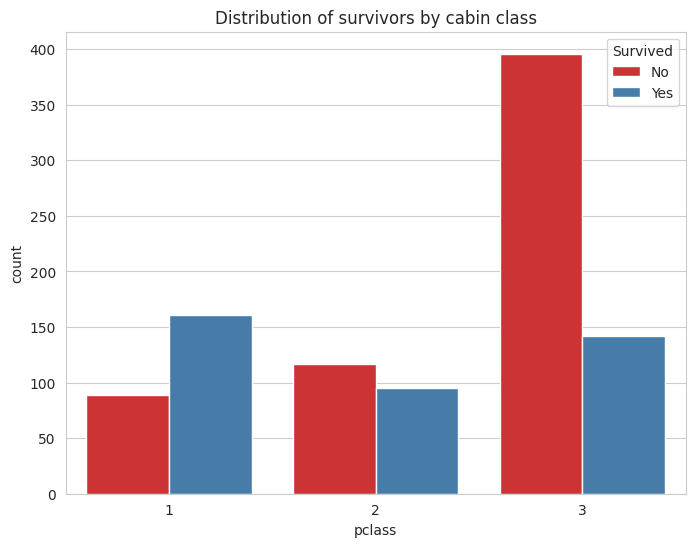

In [98]:
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='pclass', hue='survived')
plt.title('Distribution of survivors by cabin class')
plt.legend(title='Survived', labels=['No', 'Yes'])
plt.show()

>First class passengers had the highest survival rate compared to other classes. This may be due to the fact that first class cabins were closer to the lifeboats or to the higher status of passengers in this class.

> 

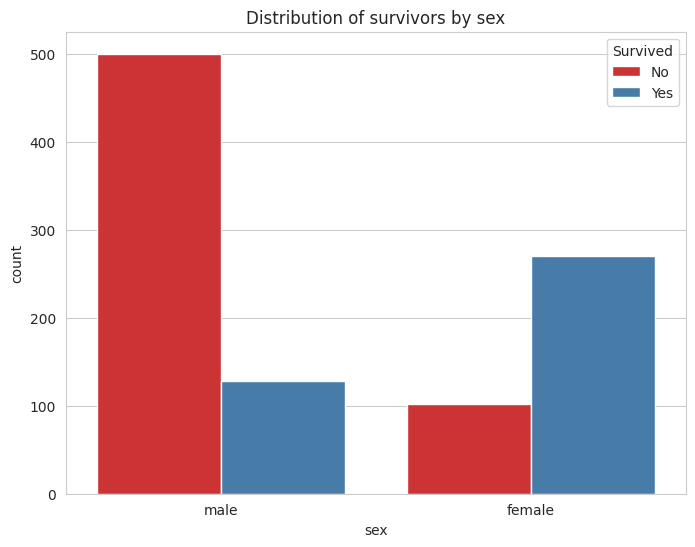

In [99]:
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='sex', hue='survived')
plt.title('Distribution of survivors by sex')
plt.legend(title='Survived', labels=['No', 'Yes'])
plt.show()

> The number of female survivors far exceeds the number of male survivors. This may indicate that women and children were given the opportunity to escape in the first place.

> ☝️ Based on the data visualisation performed, it can be inferred that the attributes considered are weighted in the context of passenger survival. These observations support the need to include these attributes in our future models for more accurate prediction.

In [100]:
# Create a new column "cabin_known". If the value in the "cabin" column is not a missing value, put 1, otherwise 0
data['cabin_known'] = data['cabin'].notnull().astype(int)
eval['cabin_known'] = eval['cabin'].notnull().astype(int)

In [101]:
# Create a new column "homedest_known". If the value in the "home.dest" column is not a missing value, put 1, otherwise 0
data['homedest_known'] = data['home.dest'].notnull().astype(int)
eval['homedest_known'] = eval['home.dest'].notnull().astype(int)


In [102]:
# Delete not useful data
data.drop('name', axis=1, inplace=True)
data.drop('ID', axis=1, inplace=True)
eval.drop('name', axis=1, inplace=True)

In [103]:
# Conversion of text data to numeric type
string_cols = data.select_dtypes(['object']).columns
data[string_cols] = data[string_cols].astype('category').apply(lambda x: x.cat.codes)
eval[string_cols] = eval[string_cols].astype('category').apply(lambda x: x.cat.codes)
data.info()
display(eval.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   survived        1000 non-null   int64  
 1   pclass          1000 non-null   int64  
 2   sex             1000 non-null   int8   
 3   age             802 non-null    float64
 4   sibsp           1000 non-null   int64  
 5   parch           1000 non-null   int64  
 6   ticket          1000 non-null   int16  
 7   fare            999 non-null    float64
 8   cabin           1000 non-null   int16  
 9   embarked        1000 non-null   int8   
 10  home.dest       1000 non-null   int16  
 11  cabin_known     1000 non-null   int64  
 12  homedest_known  1000 non-null   int64  
dtypes: float64(2), int16(3), int64(6), int8(2)
memory usage: 70.4 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  

None

In [104]:
# kontolování
display(data.head(10))
display(eval.head(10))

,survived,pclass,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest,cabin_known,homedest_known
0,0,3,1,11.0,5,2,617,46.9000,-1,2,304,0,1
1,0,3,1,NaN,0,0,698,7.0500,-1,2,-1,0,0
2,0,3,1,4.0,3,2,378,27.9000,-1,2,-1,0,0
3,1,3,0,NaN,1,0,506,15.5000,-1,1,-1,0,0
4,1,3,0,18.0,0,0,207,7.2292,-1,0,114,0,1
5,0,2,1,21.0,1,0,248,11.5000,-1,2,66,0,1
6,0,3,1,28.5,0,0,541,16.1000,-1,2,-1,0,0
7,0,3,1,33.0,0,0,553,8.6542,-1,2,-1,0,0
8,0,2,1,28.0,0,0,113,13.5000,-1,2,107,0,1
9,1,3,0,14.0,1,0,201,11.2417,-1,0,-1,0,0


,ID,pclass,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest,cabin_known,homedest_known
0,1000,3,1,33.0,0,0,155,8.6625,-1,0,-1,0,0
1,1001,1,0,NaN,0,0,245,31.6833,-1,2,78,0,1
2,1002,1,0,NaN,1,0,251,133.6500,-1,2,78,0,1
3,1003,3,1,47.0,0,0,121,9.0000,-1,2,-1,0,0
4,1004,1,0,58.0,0,0,240,146.5208,11,0,-1,1,0
5,1005,1,0,64.0,1,1,6,26.5500,6,2,75,1,1
6,1006,3,1,50.0,0,0,212,8.0500,-1,2,-1,0,0
7,1007,1,1,54.0,0,1,173,77.2875,34,2,18,1,1
8,1008,1,1,51.0,0,0,10,26.5500,42,2,63,1,1
9,1009,1,0,38.0,1,0,246,71.2833,27,0,78,1,1


> I haven't replaced the null values for ages and fare yet

# Preparing a training and validation set

> First, we divide the dataset into the target variable we want to predict and the attribute matrix from which we will predict.
> 
> In our case, the target variable is survived

In [105]:
Xdata = data.drop('survived', axis=1)
ydata = data.survived

In [106]:
rd_seed = 333 # data is distributed randomly, but it is good to have a fixed random seed in testing
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size=0.4, random_state=rd_seed) 
display(Xtrain.shape)
display(ytrain.shape)
display(Xtest.shape)
display(ytest.shape)

(600, 12)

(600,)

(400, 12)

(400,)

In [107]:
Xval, Xtest, yval, ytest = train_test_split(Xtest, ytest, test_size=0.5, random_state=rd_seed) 
display(Xval.shape)
display(yval.shape)
display(Xtest.shape)
display(ytest.shape)

(200, 12)

(200,)

(200, 12)

(200,)

In [108]:
# Calculate the median based on the training set
median_age = Xtrain['age'].median()
median_fare = Xtrain['fare'].median()

# Filling in missing values in the training set
Xtrain['age'].fillna(median_age, inplace=True)
Xtrain['fare'].fillna(median_fare, inplace=True)

# Filling in missing values in test and validation sets
Xtest['age'].fillna(median_age, inplace=True)
Xval['age'].fillna(median_age, inplace=True)
Xtest['fare'].fillna(median_fare, inplace=True)
Xval['fare'].fillna(median_fare, inplace=True)

# Also for the evaluation dataset
eval['age'].fillna(median_age, inplace=True)
eval['fare'].fillna(median_fare, inplace=True)

> ☝️ I use the median age and fare from the training data to fill in the gaps in the new data, 
to avoid data leakage and maintain the consistency of the preprocessing.

# Decision tree

> A decision tree is suitable for the task of classifying survivors of the 'Titanic' because it allows us to easily interpret and visualise decisions based on various attributes such as ticket class, age and sex. This can help us understand which factors most influenced the probability of survival. But you have to be careful because the model can be overtrained

In [109]:
from sklearn.tree import DecisionTreeClassifier

## Tuning hyperparameters

In [117]:
from sklearn.model_selection import ParameterGrid
import sklearn.metrics as metrics
# Define the grid of my chosen hyperparameters
param_grid = {
    'max_depth': range(1,31), 
    'criterion': ['entropy', 'gini'],
    'min_samples_split': range(2, 31), # 3% of data
    'min_samples_leaf' : range(2, 31) # 3% of data
}
param_comb = ParameterGrid(param_grid)


In [118]:
val_acc = []
train_acc = []
# Try all combinations of hyperparameters
for params in param_comb:
    clf = DecisionTreeClassifier(max_depth=params['max_depth'], criterion=params['criterion'], min_samples_split=params['min_samples_split'], min_samples_leaf=params['min_samples_leaf'])
    clf.fit(Xtrain, ytrain)
    train_acc.append(metrics.accuracy_score(ytrain, clf.predict(Xtrain)))
    val_acc.append(metrics.accuracy_score(yval, clf.predict(Xval)))

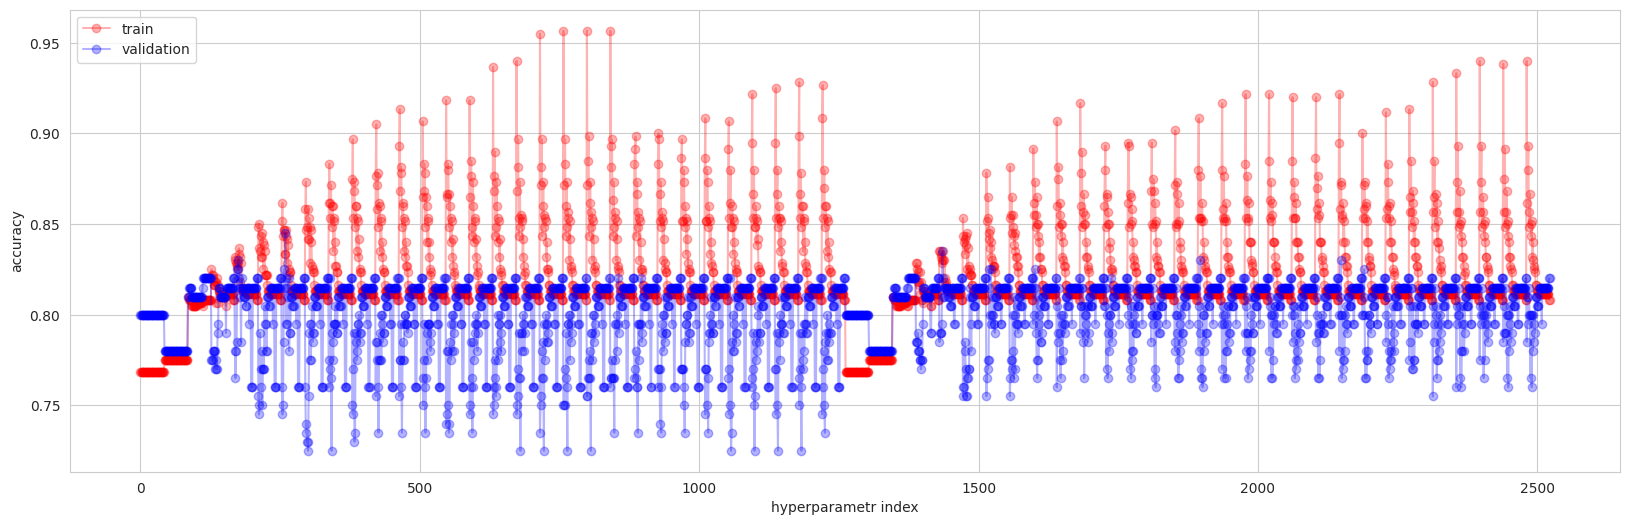

In [119]:
# Visualisation of accuracy results
step = 20

plt.figure(figsize=(20,6))
plt.plot(train_acc[::step], 'or-', alpha=0.3)
plt.plot(val_acc[::step], 'ob-', alpha=0.3)
plt.xlabel('hyperparametr index')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])
plt.show()

>The visualisation is not quite good because of the large number of parameters. But we can see that the parameters have a strong influence, somewhere there is a big gap and somewhere the gap between trains and validation data is small - that's what we need.

## Best model

In [120]:
# Selection of the best hyperparameters based on validation data
best_params = param_comb[np.argmax(val_acc)]
best_params

{'min_samples_split': 17,
 'min_samples_leaf': 5,
 'max_depth': 7,
 'criterion': 'entropy'}

In [121]:
# Training a decision tree with the best hyperparameters and calculating its accuracy
best_tree = DecisionTreeClassifier(max_depth=best_params['max_depth'], criterion=best_params['criterion'], min_samples_split=best_params['min_samples_split'], min_samples_leaf=best_params['min_samples_leaf'])
best_tree.fit(Xtrain, ytrain)
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, best_tree.predict(Xtrain))))
print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, best_tree.predict(Xval))))

accuracy score (train): 0.840000
accuracy score (validation): 0.840000


In [122]:
from sklearn.metrics import f1_score

y_pred = best_tree.predict(Xtest)
f1 = f1_score(ytest, y_pred)
print("F1 Score:", f1)

F1 Score: 0.7167630057803468


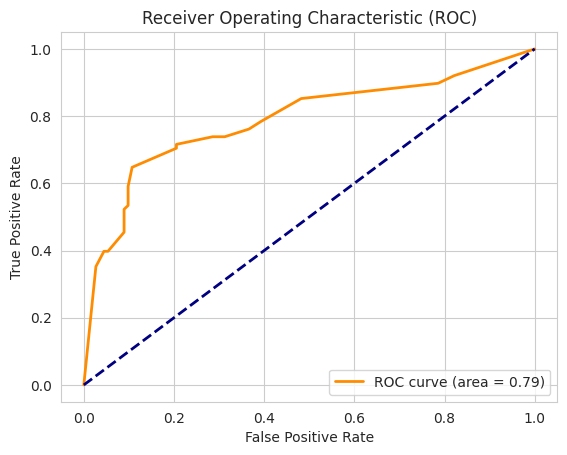

In [123]:
from sklearn.metrics import roc_curve, auc

# Calculate the probabilities for the positive class
y_prob = best_tree.predict_proba(Xtest)[:,1]

# Calculate values for ROC curve and AUC-score
fpr, tpr, thresholds = roc_curve(ytest, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

> The decision tree for the Titanic dataset showed an F1-score of 0.717 and an AUC value of 0.79. These values indicate that the model has a decent prediction quality. The ROC curve plot above the diagonal line also confirms the effectiveness of the model compared to random prediction. Abrupt jumps in the ROC curve of a decision tree model may be an indication that the model is making decisions based on specific thresholds or rules, which is characteristic of decision trees.

# K-Nearest Neighbors (KNN)

> The k-nearest neighbours (k-NN) model may be appropriate for the Titanic dataset as it works well with classification tasks where relationships between classes can be determined based on feature similarity. The efficiency of k-NN decreases with increasing number of dimensions (features) due to the increasing volume of space, which makes it difficult to find nearest neighbours in sparse spaces. But we do not have such a large number of features. We have well structured data and k-NN can give good results. 

In [124]:
from sklearn.neighbors import KNeighborsClassifier

In [125]:
# Base implementation from sklearn
clf = KNeighborsClassifier()
clf.fit(Xtrain, ytrain)
print(f"Validation accuracy: {metrics.accuracy_score(yval, clf.predict(Xval)):0.4f}")

Validation accuracy: 0.6550


In [126]:
# Try to use normalization
from sklearn.preprocessing import MinMaxScaler
# Min-max scaler fit on training data
scaler = MinMaxScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)

# Then we apply the same transformation to the validation data
Xval_scaled = scaler.transform(Xval)

# Natrénujeme model na transformovaných datech
clf = KNeighborsClassifier()
clf.fit(Xtrain_scaled, ytrain)

print(f"Validation accuracy of normalized model: {clf.score(Xval_scaled, yval):0.4f}")

Validation accuracy of normalized model: 0.8000


> Given this result, it makes sense to continue tuning the hyperparameters only for the normalised model.

## Tuning hyperparameters

In [39]:
param_grid_knn = {
    'n_neighbors': range(1,16),
    'weights': ['uniform', 'distance'], 
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'hamming', 'cosine']
}


param_grid_knn_minkowski = {
    'n_neighbors': range(1,16),
    'weights': ['uniform', 'distance'], 
    'p': [2**i for i in range(20)] 
}

param_comb_knn1 = ParameterGrid(param_grid_knn)
param_comb_knn2 = ParameterGrid(param_grid_knn_minkowski)

> I've chosen a set of different distance metrics to see which ones work best for dataset. In the case of the Minkowski metric, I investigate degrees of two, starting from 1 to 2^19. At large values of p the Minkowski distance approaches the Chebyshev metric.

> Now I will test these parameters on different scalars, considering it also as a hypperparameter

### MinMaxScaler

In [40]:
# Min-max scaler fit on training data
scaler = MinMaxScaler()
Xtrain_scaled_minmax = scaler.fit_transform(Xtrain)

# Then we apply the same transformation to the validation data
Xval_scaled_minmax = scaler.transform(Xval)
# And test data
Xtest_scaled_minmax = scaler.transform(Xtest)

In [41]:
# as well as decision trees
val_acc_knn1 = []
train_acc_knn1 = []
val_acc_knn2 = []
train_acc_knn2 = []

for params in param_comb_knn1:
    clf = KNeighborsClassifier(n_neighbors = params['n_neighbors'], weights=params['weights'], metric=params['metric'])
    clf.fit(Xtrain_scaled_minmax, ytrain)
    train_acc_knn1.append(metrics.accuracy_score(ytrain, clf.predict(Xtrain_scaled_minmax)))
    val_acc_knn1.append(metrics.accuracy_score(yval, clf.predict(Xval_scaled_minmax)))

for params in param_comb_knn2:
    clf = KNeighborsClassifier(n_neighbors = params['n_neighbors'], weights=params['weights'], p=params['p'])
    clf.fit(Xtrain_scaled_minmax, ytrain)
    train_acc_knn2.append(metrics.accuracy_score(ytrain, clf.predict(Xtrain_scaled_minmax)))
    val_acc_knn2.append(metrics.accuracy_score(yval, clf.predict(Xval_scaled_minmax)))

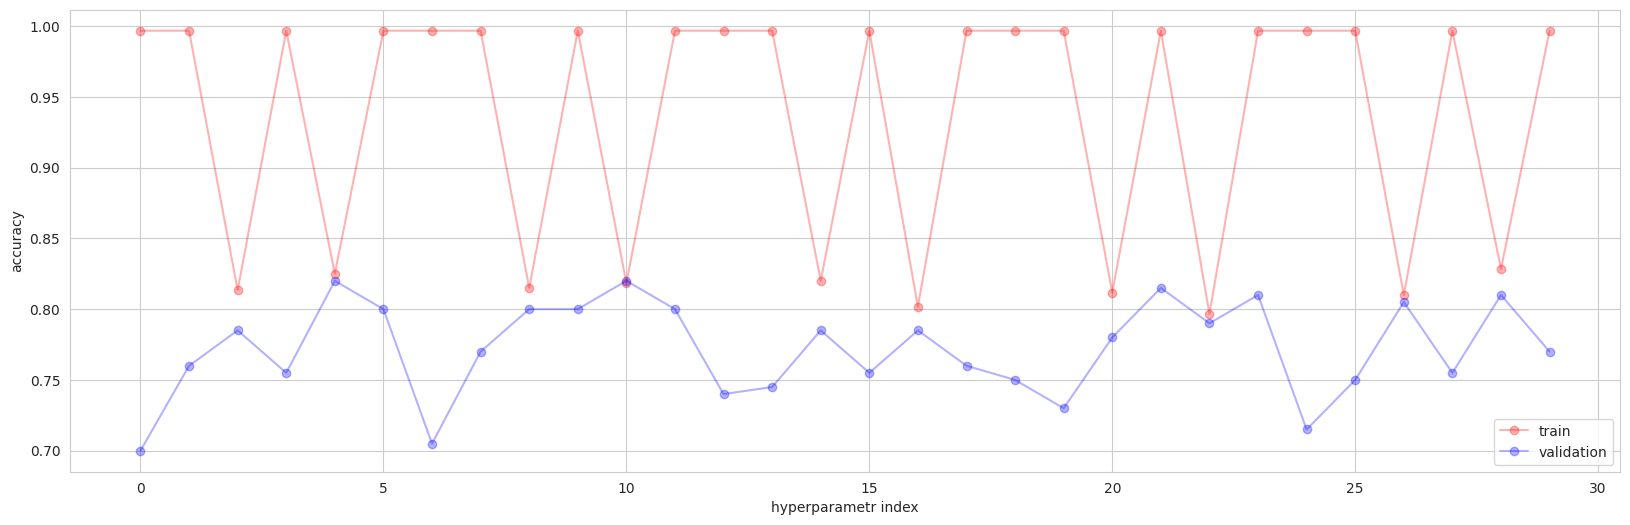

In [42]:
# Visualisation of accuracy results
step = 5

plt.figure(figsize=(20,6))
plt.plot(train_acc_knn1[::step], 'or-', alpha=0.3)
plt.plot(val_acc_knn1[::step], 'ob-', alpha=0.3)
plt.xlabel('hyperparametr index')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])

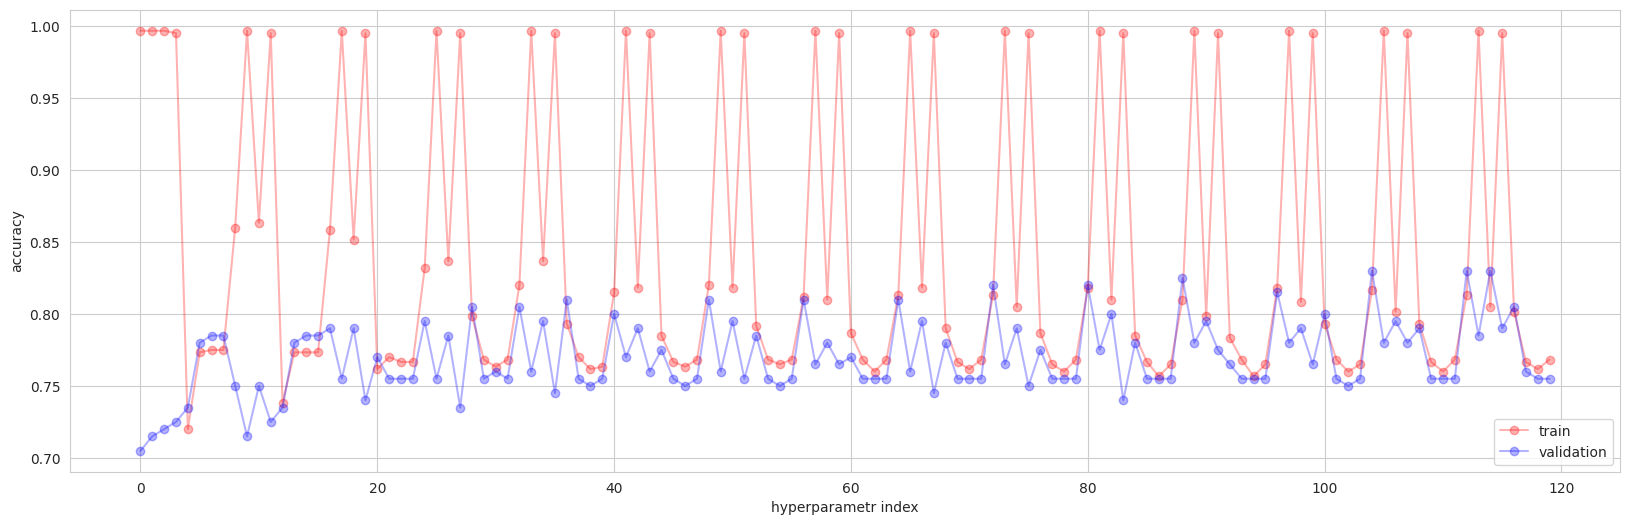

In [43]:
step = 5

plt.figure(figsize=(20,6))
plt.plot(train_acc_knn2[::step], 'or-', alpha=0.3)
plt.plot(val_acc_knn2[::step], 'ob-', alpha=0.3)
plt.xlabel('hyperparametr index')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])

> Accuracy for the validation set ranges from 0.7 to 0.85. Again overtraining is observed for some parameters. On the validation data, the models shows lower and more stable accuracy.

### StandardScaler

In [44]:
from sklearn.preprocessing import StandardScaler

# Now we try use standard scaler
scaler = StandardScaler()
Xtrain_scaled_std = scaler.fit_transform(Xtrain)
Xval_scaled_std = scaler.fit_transform(Xval)
Xtest_scaled_std = scaler.fit_transform(Xtest)

In [45]:
# as well as decision trees
val_acc_knn3 = []
train_acc_knn3 = []
val_acc_knn4 = []
train_acc_knn4 = []

for params in param_comb_knn1:
    clf = KNeighborsClassifier(n_neighbors = params['n_neighbors'], weights=params['weights'], metric=params['metric'])
    clf.fit(Xtrain_scaled_std, ytrain)
    train_acc_knn3.append(metrics.accuracy_score(ytrain, clf.predict(Xtrain_scaled_std)))
    val_acc_knn3.append(metrics.accuracy_score(yval, clf.predict(Xval_scaled_std)))

for params in param_comb_knn2:
    clf = KNeighborsClassifier(n_neighbors = params['n_neighbors'], weights=params['weights'], p=params['p'])
    clf.fit(Xtrain_scaled_std, ytrain)
    train_acc_knn4.append(metrics.accuracy_score(ytrain, clf.predict(Xtrain_scaled_std)))
    val_acc_knn4.append(metrics.accuracy_score(yval, clf.predict(Xval_scaled_std)))

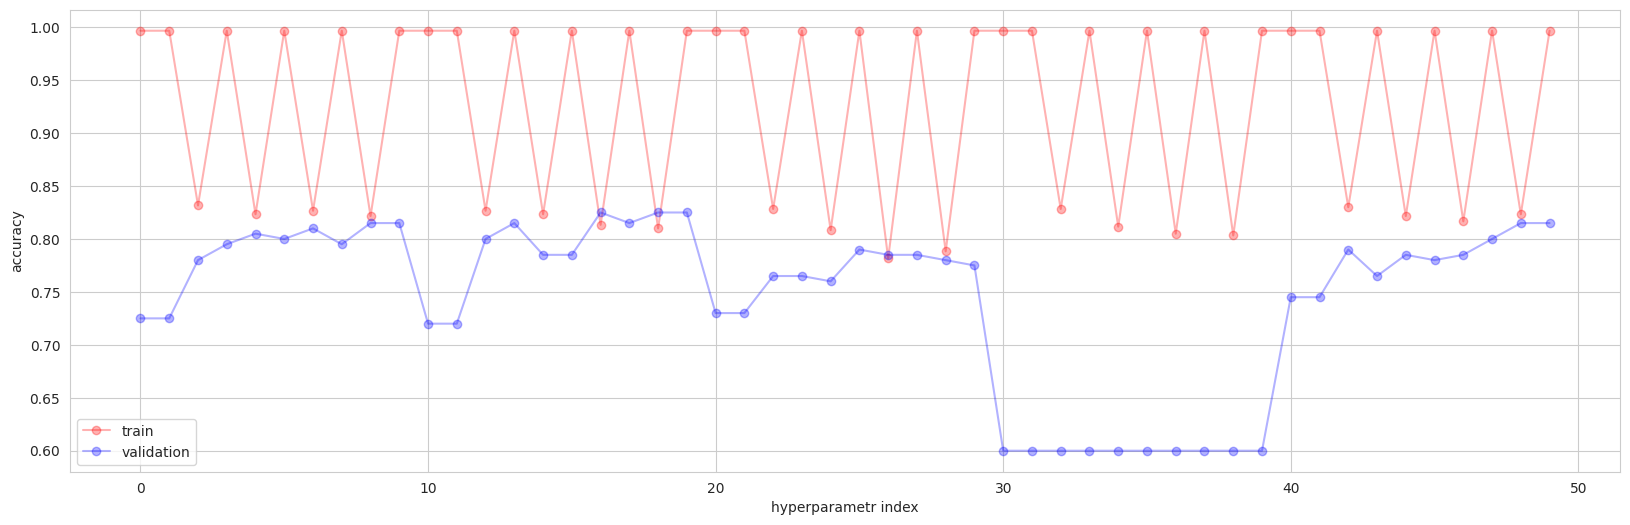

In [46]:
# Visualisation of accuracy results
step = 3

plt.figure(figsize=(20,6))
plt.plot(train_acc_knn3[::step], 'or-', alpha=0.3)
plt.plot(val_acc_knn3[::step], 'ob-', alpha=0.3)
plt.xlabel('hyperparametr index')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])

> Some models are overtrained(100% on train and then low results on validation data) and t some points, the accuracy on the validation data drops sharply, which may indicate that the model is being retrained for certain hyperparameters.

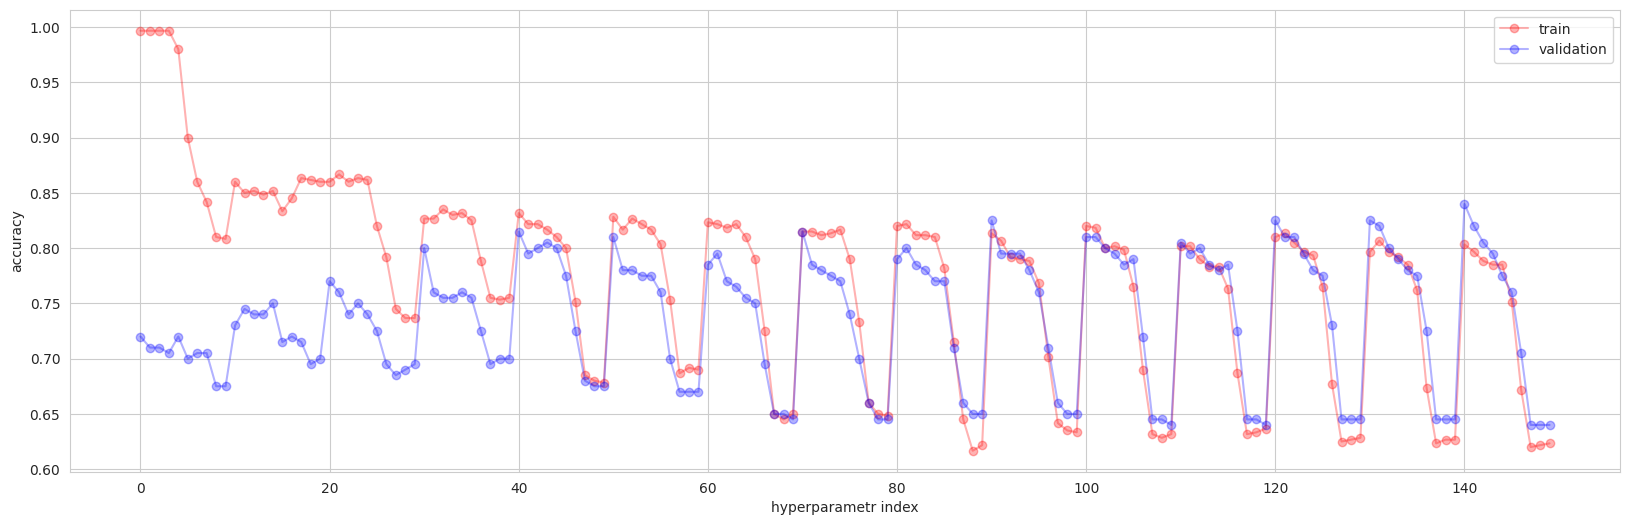

In [47]:
# Visualisation of accuracy results
step = 4

plt.figure(figsize=(20,6))
plt.plot(train_acc_knn4[::step], 'or-', alpha=0.3)
plt.plot(val_acc_knn4[::step], 'ob-', alpha=0.3)
plt.xlabel('hyperparametr index')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])

> The model seems to be more sensitive to changes in the hyperparameters in the lower plot, as the variation in accuracy on the validation dataset is more pronounced.

## Best KNN model

In [48]:
best_params1 = param_comb_knn1[np.argmax(val_acc_knn1)]
best_params1

{'weights': 'uniform', 'n_neighbors': 15, 'metric': 'hamming'}

In [49]:
best_KNN1 = KNeighborsClassifier(n_neighbors = best_params1['n_neighbors'], weights=best_params1['weights'], metric=best_params1['metric'])
best_KNN1.fit(Xtrain_scaled_minmax, ytrain)
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, best_KNN1.predict(Xtrain_scaled_minmax))))
print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, best_KNN1.predict(Xval_scaled_minmax))))

accuracy score (train): 0.806667
accuracy score (validation): 0.845000


In [50]:
best_params2 = param_comb_knn2[np.argmax(val_acc_knn2)]
best_params2

{'weights': 'uniform', 'p': 1, 'n_neighbors': 14}

In [51]:
best_KNN2 = KNeighborsClassifier(n_neighbors = best_params2['n_neighbors'], weights=best_params2['weights'], p=best_params2['p'] )
best_KNN2.fit(Xtrain_scaled_minmax, ytrain)
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, best_KNN2.predict(Xtrain_scaled_minmax))))
print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, best_KNN2.predict(Xval_scaled_minmax))))

accuracy score (train): 0.816667
accuracy score (validation): 0.830000


In [52]:
best_params3 = param_comb_knn1[np.argmax(val_acc_knn3)]
best_params3

{'weights': 'uniform', 'n_neighbors': 15, 'metric': 'manhattan'}

In [53]:
best_KNN3 = KNeighborsClassifier(n_neighbors = best_params3['n_neighbors'], weights=best_params3['weights'], metric=best_params3['metric'])
best_KNN3.fit(Xtrain_scaled_std, ytrain)
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, best_KNN3.predict(Xtrain_scaled_std))))
print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, best_KNN3.predict(Xval_scaled_std))))

accuracy score (train): 0.803333
accuracy score (validation): 0.840000


In [54]:
best_params4 = param_comb_knn2[np.argmax(val_acc_knn4)]
best_params4

{'weights': 'uniform', 'p': 1, 'n_neighbors': 15}

In [55]:
best_KNN4 = KNeighborsClassifier(n_neighbors = best_params4['n_neighbors'], weights=best_params4['weights'], p=best_params4['p'])
best_KNN4.fit(Xtrain_scaled_std, ytrain)
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, best_KNN4.predict(Xtrain_scaled_std))))
print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, best_KNN4.predict(Xval_scaled_std))))

accuracy score (train): 0.803333
accuracy score (validation): 0.840000


> Based on these findings, the KNN1 model shows the best accuracy on the validation data (0.845000), while maintaining acceptable accuracy on the training set (0.806667). This suggests that the KNN1 model best summarises the data studied and is the preferred choice amongst those presented.

In [56]:
# Best of all KNNs
best_KNN = best_KNN1
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, best_KNN.predict(Xtrain_scaled_minmax))))
print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, best_KNN.predict(Xval_scaled_minmax))))

accuracy score (train): 0.806667
accuracy score (validation): 0.845000


In [57]:
y_pred = best_KNN.predict(Xtest_scaled_minmax)
f1 = f1_score(ytest, y_pred)
print("F1 Score:", f1)

F1 Score: 0.6787878787878787


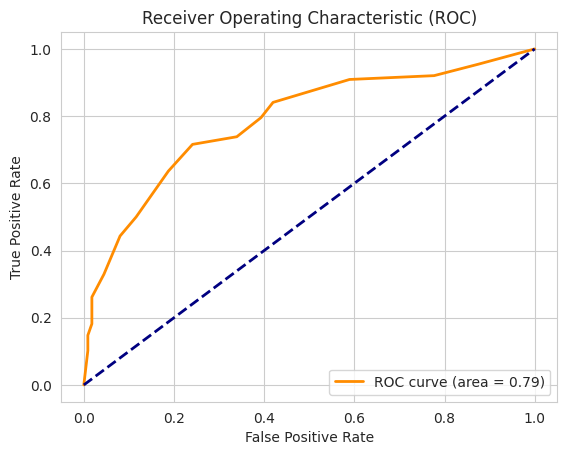

In [58]:
# Calculate the probabilities for the positive class
y_prob = best_KNN.predict_proba(Xtest_scaled_minmax)[:,1]

# Calculate values for ROC curve and AUC-score
fpr, tpr, thresholds = roc_curve(ytest, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

> The F1 Score above is about 0.68. This indicates that the model has a moderate  balance between completeness and accuracy. A AUC value around 0.79 indicates a fairly good quality model. The smooth ROC rounding means that an increase in the proportion of true positives (TPR) occurs with a relatively small increase in the proportion of false positives (FPR), a sign of a qualitative model.

# Final model and results

> Both models have almost the same accuracy on validation data (0.840000 for tree and 0.845000 for knn) 
> 
> F1-score: The decision tree has slightly a higher F1-score (approximately 0.717 vs. 0.68 for k-NN), indicating a better balance between accuracy and completeness.
> 
> ROC-AUC: Both models show similar performance in terms of ROC-AUC (0.79 for both models), which means that both models are about equally good at discriminating between classes.
>
> looks like there's not much difference, so I'll just pick a decision tree.

In [127]:
# test the final model
best_model = best_tree
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, best_model.predict(Xtest))))

accuracy score (test): 0.755000


> We can say that the accuracy when working with new data that were not used during training and selection of parameters and model will be 75,5%

In [130]:
eval_features = eval.drop(columns=['ID'], errors='ignore')

# Get predictions from the model
predictions = best_model.predict(eval_features)

# DataFrame for the results
results = pd.DataFrame({
    'ID': eval['ID'],  
    'survived': predictions
})

# Saving results
results.to_csv('results.csv', index=False)

In [132]:
#Let's have a look
value_counts = results['survived'].value_counts()
print(value_counts)

survived
0    196
1    113
Name: count, dtype: int64


# P.S.

> Materials used:
>
> 1. Notebooks from class 02 and 04
> 2. chat GPT - technical issues related to working with libraries

Thank you for the task!